In [65]:
import pandas as pd

# Load the data from the uploaded CSV file
data_path = 'out.csv'
data = pd.read_csv(data_path)

# Display the first few rows of the dataset and its structure
data.head(), data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1268 entries, 0 to 1267
Data columns (total 26 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Unnamed: 0                    1268 non-null   int64  
 1   id                            1268 non-null   object 
 2   date                          1268 non-null   object 
 3   activity                      1268 non-null   float64
 4   circumplex.arousal            1268 non-null   float64
 5   circumplex.valence            1268 non-null   float64
 6   mood                          1268 non-null   float64
 7   appCat.builtin                1268 non-null   float64
 8   appCat.communication          1268 non-null   float64
 9   appCat.entertainment          1268 non-null   float64
 10  appCat.finance                1268 non-null   float64
 11  appCat.game                   1268 non-null   float64
 12  appCat.office                 1268 non-null   float64
 13  app

(   Unnamed: 0       id        date  activity  circumplex.arousal  \
 0           7  AS14.01  2014-02-26  0.081548               -0.25   
 1           8  AS14.01  2014-02-27  0.081548                0.00   
 2          26  AS14.01  2014-03-21  0.134050                0.20   
 3          27  AS14.01  2014-03-22  0.236880                0.60   
 4          28  AS14.01  2014-03-23  0.142741                0.20   
 
    circumplex.valence      mood  appCat.builtin  appCat.communication  \
 0            0.750000  6.250000           0.000                 0.000   
 1            0.333333  6.333333           0.000                 0.000   
 2            0.200000  6.200000        1090.617              2850.042   
 3            0.500000  6.400000         476.737              1946.683   
 4            0.800000  6.800000         540.915              2680.535   
 
    appCat.entertainment  ...  appCat.unknown  appCat.utilities  \
 0                 0.000  ...             0.0             0.000   
 1  

In [66]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
import numpy as np

data['mood_quantiles_shifted'] = data['mood_quantiles'].shift(1)
print(data.head())
features = data.drop(['mood', 'id', 'screen', 'Unnamed: 0', 'mood_quantiles', 'date'], axis=1)
target = data['mood_quantiles']

features = features.drop(features.index[0])
target = target.drop(target.index[0])


print(features.head())
print(features.info())

label_encoder = LabelEncoder()

# Encode the targets
target_encoded = label_encoder.fit_transform(target)

label_encoder.fit(data['mood_quantiles'])  # Fit to the whole column to ensure all possible labels are encoded
features['mood_quantiles_shifted'] = label_encoder.transform(features['mood_quantiles_shifted'])

numeric_features = features.select_dtypes(include=['int64', 'float64'])

scaler = StandardScaler()
numeric_features_scaled = scaler.fit_transform(numeric_features.fillna(numeric_features.mean()))

features[numeric_features.columns] = numeric_features_scaled
features_scaled = scaler.fit_transform(features.fillna(features.mean())) # Function to create sequences

# Convert to numpy arrays
features_np = np.array(features_scaled)
target_np = np.array(target)

# Create sequences for LSTM
def create_sequences(features, target, window_size):
    X, y = [], []
    for i in range(len(features) - window_size):
        X.append(features[i:(i + window_size)])
        y.append(target[i + window_size])
    return np.array(X), np.array(y)

# Assuming we use a window size of 10 days
window_size = 10
X, y = create_sequences(features_np, target_np, window_size)

X.shape, y.shape


   Unnamed: 0       id        date  activity  circumplex.arousal  \
0           7  AS14.01  2014-02-26  0.081548               -0.25   
1           8  AS14.01  2014-02-27  0.081548                0.00   
2          26  AS14.01  2014-03-21  0.134050                0.20   
3          27  AS14.01  2014-03-22  0.236880                0.60   
4          28  AS14.01  2014-03-23  0.142741                0.20   

   circumplex.valence      mood  appCat.builtin  appCat.communication  \
0            0.750000  6.250000           0.000                 0.000   
1            0.333333  6.333333           0.000                 0.000   
2            0.200000  6.200000        1090.617              2850.042   
3            0.500000  6.400000         476.737              1946.683   
4            0.800000  6.800000         540.915              2680.535   

   appCat.entertainment  ...  appCat.utilities  appCat.weather  call  \
0                 0.000  ...             0.000           0.000   1.0   
1       

((1257, 10, 21), (1257,))

In [67]:
import torch
import torch.nn as nn
import torch.nn.functional as F  # This will be needed for the softmax activation

class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_classes, num_layers=1):
        super(LSTMModel, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        # Define the LSTM layer
        self.lstm = nn.LSTM(self.input_dim, self.hidden_dim, self.num_layers, batch_first=True)

        # Define the output layer, now output_dim should match num_classes
        self.linear = nn.Linear(self.hidden_dim, num_classes)

    def forward(self, input):
        # Get the current batch size from input
        current_batch_size = input.size(0)

        # Initialize hidden state with zeros
        h0 = torch.zeros(self.num_layers, current_batch_size, self.hidden_dim).requires_grad_()

        # Initialize cell state
        c0 = torch.zeros(self.num_layers, current_batch_size, self.hidden_dim).requires_grad_()

        # We need to detach as we are doing truncated backpropagation through time (BPTT)
        lstm_out, (hn, cn) = self.lstm(input, (h0.detach(), c0.detach()))

        # Only take the output from the final timestep
        out = self.linear(lstm_out[:, -1, :])

        # Apply softmax on the final layer (optional here, necessary if not using CrossEntropyLoss)
        return F.log_softmax(out, dim=1)  # Use log_softmax if using NLLLoss, or just out if using CrossEntropyLoss

# Parameters for the model
input_dim = 21 # number of features
hidden_dim = 50
batch_size = 64
num_layers = 1
num_classes = 4  # Change this to the number of your mood quantiles

# Create the LSTM model instance
model = LSTMModel(input_dim, hidden_dim, num_classes, num_layers)
print(model)

LSTMModel(
  (lstm): LSTM(20, 50, batch_first=True)
  (linear): Linear(in_features=50, out_features=4, bias=True)
)


In [68]:
import torch
from torch.utils.data import DataLoader, TensorDataset, random_split
import matplotlib.pyplot as plt

# Convert numpy arrays to PyTorch tensors
X_tensor = torch.tensor(X, dtype=torch.float32)
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(y)
y_tensor = torch.tensor(encoded_labels, dtype=torch.long)  # Use torch.long for categorical targets
#y_tensor = labels_tensor.view(-1, 1)

# Create a TensorDataset
dataset = TensorDataset(X_tensor, y_tensor)

# Split the dataset into training and validation sets
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create DataLoaders for training and validation sets
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False)

# Initialize the model
model = LSTMModel(input_dim, hidden_dim, num_classes, num_layers)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Function to calculate the loss over a whole dataset (for validation)
def evaluate(model, val_loader):
    model.eval()
    with torch.no_grad():
        losses = []
        for X_batch, y_batch in val_loader:
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            losses.append(loss.item())
        return sum(losses) / len(losses)

# Training loop
num_epochs = 50
train_losses = []
val_losses = []
for epoch in range(num_epochs):
    model.train()
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()
    train_loss = evaluate(model, train_loader)
    val_loss = evaluate(model, val_loader)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    print(f'Epoch {epoch+1}, Training Loss: {train_loss}, Validation Loss: {val_loss}')






RuntimeError: input.size(-1) must be equal to input_size. Expected 20, got 21

In [ ]:
# def train_model(model, train_loader, criterion, optimizer, num_epochs=10):
#     for epoch in range(num_epochs):
#         model.train()
#         for X_batch, y_batch in train_loader:
#             optimizer.zero_grad()
#             y_pred = model(X_batch)
#             loss = criterion(y_pred, y_batch)
#             loss.backward()
#             optimizer.step()

# def evaluate(model, val_loader):
#     model.eval()
#     total_loss = 0
#     with torch.no_grad():
#         for X_batch, y_batch in val_loader:
#             y_pred = model(X_batch)
#             loss = criterion(y_pred, y_batch)
#             total_loss += loss.item()
#     return total_loss / len(val_loader)


In [ ]:
# import torch
# from torch.utils.data import DataLoader, TensorDataset, random_split
# import matplotlib.pyplot as plt
# from sklearn.model_selection import TimeSeriesSplit


# n_splits = 5
# tscv = TimeSeriesSplit(n_splits=n_splits)

# import numpy as np
# import torch
# from torch.utils.data import DataLoader, TensorDataset

# # Assuming you have prepared your entire dataset:
# # X_all and y_all are your features and labels, respectively, in a numpy array format
# X_tensor = torch.tensor(X, dtype=torch.float32)
# X_tensor = torch.tensor(y, dtype=torch.float32).view(-1, 1)

# dataset = TensorDataset(X_tensor, X_tensor)

# for train_index, val_index in tscv.split(X_tensor):
#     # Create training and validation sets for this fold
#     X_train, X_val = X_tensor[train_index], X_tensor[val_index]
#     y_train, y_val = X_tensor[train_index], X_tensor[val_index]

#     # Create DataLoader for training and validation
#     train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=64, shuffle=False)
#     val_loader = DataLoader(TensorDataset(X_val, y_val), batch_size=64, shuffle=False)

#     # Initialize and train your LSTM model
#     model = LSTMModel(input_dim, hidden_dim, output_dim=1, num_layers=1)
#     optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
#     criterion = torch.nn.MSELoss()

#     # Example training function (you might need to define it depending on your LSTM setup)
#     train_model(model, train_loader, criterion, optimizer)

#     # Evaluate the model on the validation set
#     validation_loss = evaluate(model, val_loader)
#     print(f"Validation loss for fold {fold}: {validation_loss}")
#     fold += 1






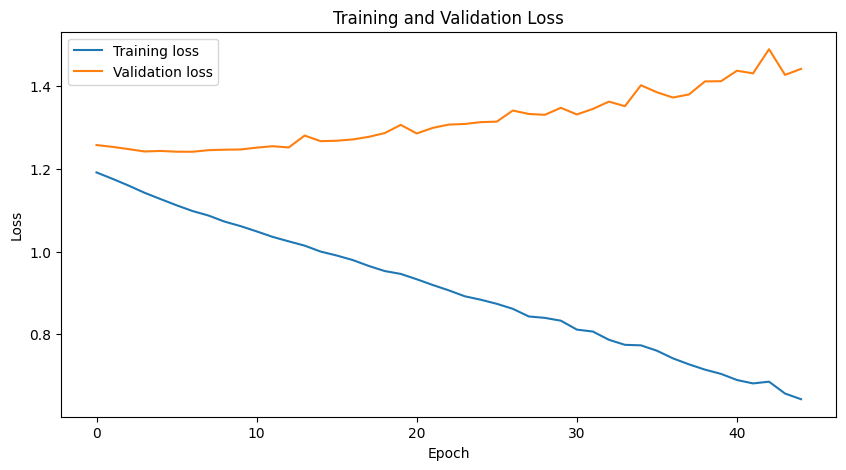

In [ ]:

# Plotting the training and validation losses
plt.figure(figsize=(10, 5))
plt.plot(train_losses[5:], label='Training loss')
plt.plot(val_losses[5:], label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

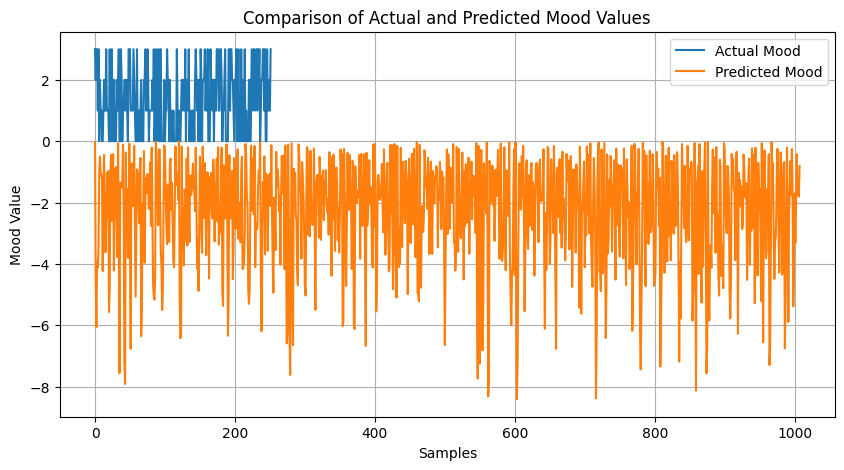

In [ ]:
import matplotlib.pyplot as plt

def get_predictions(model, data_loader):
    model.eval()
    predictions = []
    actuals = []
    with torch.no_grad():
        for X_batch, y_batch in data_loader:
            y_pred = model(X_batch)
            predictions.extend(y_pred.view(-1).tolist())
            actuals.extend(y_batch.view(-1).tolist())
    return actuals, predictions

# Get predictions and actuals for the validation set
actuals, predictions = get_predictions(model, val_loader)

# Plotting the actual vs predicted values
plt.figure(figsize=(10, 5))
plt.plot(actuals, label='Actual Mood')
plt.plot(predictions, label='Predicted Mood')
plt.title('Comparison of Actual and Predicted Mood Values')
plt.xlabel('Samples')
plt.ylabel('Mood Value')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error


# Get predictions and actuals for the validation set
actuals, predictions = get_predictions(model, val_loader)

# Calculate Mean Squared Error
mse = mean_squared_error(actuals, predictions)

# Calculate Mean Absolute 
mae = mean_absolute_error(actuals, predictions)

print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)

ValueError: Found input variables with inconsistent numbers of samples: [252, 1008]